<a href="https://colab.research.google.com/github/ImanFatasya/Wafer-Defect-Detection-using-Deep-Learning-FYP-/blob/main/New_Data_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DATA AUGMENTATION

In [ ]:
import torch
import numpy as np

# Accessing Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Load the saved data later when needed
resized_wm = torch.load('/content/drive/MyDrive/Colab Notebooks/resized_wm.pt')  # Load the feature data from the .pt file
label_wm = np.load('/content/drive/MyDrive/Colab Notebooks/label_wm.npy')        # Load the labels from the .npy file


Mounted at /content/drive


<ipython-input-1-2d00307d6a49>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resized_wm = torch.load('/content/drive/MyDrive/Colab Notebooks/resized_wm.pt')  # Load the f

In [ ]:
resized_wm.shape

torch.Size([33147, 56, 56, 3])

In [ ]:
label_wm.shape

(33147, 1)

In [ ]:
(unique, counts) = np.unique(label_wm, return_counts=True)

# Display the distribution of defect labels
distribution = dict(zip(unique, counts))
print("Defect Distribution:", distribution)

Defect Distribution: {'Center': 2341, 'Donut': 1, 'Edge-Loc': 651, 'Edge-Ring': 56, 'Loc': 469, 'Near-full': 37, 'Random': 127, 'Scratch': 95, 'none': 29370}


In [ ]:
faulty_case = np.unique(label_wm)
print(faulty_case)

['Center' 'Donut' 'Edge-Loc' 'Edge-Ring' 'Loc' 'Near-full' 'Random'
 'Scratch' 'none']


In [ ]:
import torch
import numpy as np
import torchvision.transforms as transforms

# Set device (CPU or GPU)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Augment function with data augmentation: random rotation, horizontal flip, vertical flip
def gen_data(wafer, label):
    # Define the augmentations: random rotation, horizontal flip, vertical flip
    augmentations = transforms.Compose([
        transforms.RandomRotation(degrees=30),  # Random rotation between -30 and 30 degrees
        transforms.RandomHorizontalFlip(p=0.5),  # Random horizontal flip
        transforms.RandomVerticalFlip(p=0.5)  # Random vertical flip
    ])

    gen_x = torch.zeros((1, 3, 56, 56))  # Initialize a tensor to store augmented samples
    label_list = []  # Initialize list to store corresponding labels

    for i in range((2000 // len(wafer)) + 1):  # Targeting 2000 augmented samples
        for wafer_map in wafer:
            # Debug: Check the shape of each wafer_map
            print("Shape of wafer_map before augmentation:", wafer_map.shape)  # Should print (3, 56, 56)

            # Apply the transformations
            wafer_map_pil = transforms.ToPILImage()(wafer_map)  # Convert tensor to image (PIL)
            augmented_wafer = augmentations(wafer_map_pil)  # Apply transformations
            augmented_wafer = transforms.ToTensor()(augmented_wafer)  # Convert back to tensor

            # Append the augmented wafer and label
            gen_x = torch.cat([gen_x, augmented_wafer.unsqueeze(0)], axis=0)
            label_list.append(label)

    # Remove the first dummy tensor (initialized as zeros)
    gen_x = gen_x[1:]
    labels = np.array(label_list).reshape((-1, 1))

    return gen_x, labels

# Augmentation for all classes except 'none'
for f in faulty_case:
    if f == 'none':
        continue  # Skip the 'none' class
    # Debug: Check shape before running gen_data
    print(f"Generating augmented data for class: {f}")
    subset = resized_wm[np.where(label_wm == f)[0]].to(DEVICE)
    print(f"Shape of subset for class {f}: {subset.shape}")

    # Ensure the subset is in channels-first format (N, 3, 56, 56)
    if subset.shape[-1] == 3:  # If subset is in (N, 56, 56, 3), permute it to (N, 3, 56, 56)
        subset = subset.permute(0, 3, 1, 2)

    # Use the correct device when generating augmented data
    gen_x, gen_y = gen_data(subset, f)

    # Debug: Check the shapes before concatenation
    print(f"Shape of resized_wm before concat: {resized_wm.shape}")
    print(f"Shape of gen_x before concat: {gen_x.shape}")

    # Ensure both tensors are in channels-first format and on the same device
    resized_wm = resized_wm.to(torch.device('cpu'))  # Move resized_wm to CPU

    # Convert `resized_wm` to channels-first format if needed
    if resized_wm.shape[-1] == 3:  # If resized_wm is in (N, 56, 56, 3), permute it to (N, 3, 56, 56)
        resized_wm = resized_wm.permute(0, 3, 1, 2)

    # Ensure both tensors are on CPU
    gen_x = gen_x.to(torch.device('cpu'))

    # Combine the generated data with the original
    resized_wm = torch.cat([resized_wm, gen_x], axis=0)  # Concatenate on the first dimension (N)
    label_wm = np.concatenate((label_wm, gen_y))

Streaming output truncated to the last 5000 lines.
Shape of wafer_map before augmentation: torch.Size([3, 56, 56])
Shape of wafer_map before augmentation: torch.Size([3, 56, 56])
Shape of wafer_map before augmentation: torch.Size([3, 56, 56])
Shape of wafer_map before augmentation: torch.Size([3, 56, 56])
Shape of wafer_map before augmentation: torch.Size([3, 56, 56])
Shape of wafer_map before augmentation: torch.Size([3, 56, 56])
Shape of wafer_map before augmentation: torch.Size([3, 56, 56])
Shape of wafer_map before augmentation: torch.Size([3, 56, 56])
Shape of wafer_map before augmentation: torch.Size([3, 56, 56])
Shape of wafer_map before augmentation: torch.Size([3, 56, 56])
Shape of wafer_map before augmentation: torch.Size([3, 56, 56])
Shape of wafer_map before augmentation: torch.Size([3, 56, 56])
Shape of wafer_map before augmentation: torch.Size([3, 56, 56])
Shape of wafer_map before augmentation: torch.Size([3, 56, 56])
Shape of wafer_map before augmentation: torch.Size([3

Here is a table with the values used in the code for data augmentation:

| **Augmentation Technique**      | **Parameter**          | **Value**                    | **Explanation**                                                                                               |
|----------------------------------|------------------------|------------------------------|---------------------------------------------------------------------------------------------------------------|
| **Random Rotation**              | `degrees`              | `30`                          | Random rotation applied between -30 and 30 degrees to the wafer image. Helps model handle different orientations. |
| **Random Horizontal Flip**       | `p`                    | `0.5`                         | The probability of flipping the wafer image horizontally. 50% chance for each wafer image to be flipped.         |
| **Random Vertical Flip**         | `p`                    | `0.5`                         | The probability of flipping the wafer image vertically. 50% chance for each wafer image to be flipped.           |

These are the key parameters used in the data augmentation process. The function generates augmented samples of the wafer images by applying these transformations randomly. The objective is to make the model more robust by training it on slightly different versions of the wafer images.

In [ ]:
# Final size check
print('After Augmentation resized_wm shape: {}, label_wm shape: {}'.format(resized_wm.shape, label_wm.shape))

After Augmentation resized_wm shape: torch.Size([50611, 3, 56, 56]), label_wm shape: (50611, 1)


In [ ]:
# Clean up gen_x of 2000 augmented wafer maps, and gen_y an array where each entry is the label
del gen_x, gen_y

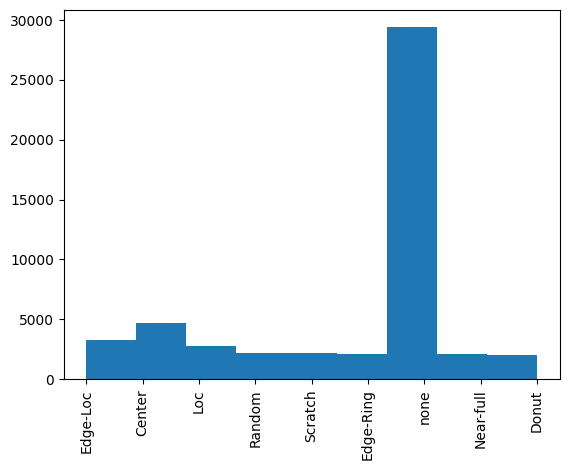

In [ ]:
import matplotlib.pyplot as plt

# Visualize the label distribution before undersampling
n, bins, patches = plt.hist(label_wm, bins=9)
plt.xticks(rotation=90)
plt.show()

In [ ]:
(unique, counts) = np.unique(label_wm, return_counts=True)

# Display the distribution of defect labels
distribution = dict(zip(unique, counts))
print("Defect Distribution:", distribution)

Defect Distribution: {'Center': 4682, 'Donut': 2002, 'Edge-Loc': 3255, 'Edge-Ring': 2072, 'Loc': 2814, 'Near-full': 2072, 'Random': 2159, 'Scratch': 2185, 'none': 29370}


# Undersampling

the data still have imbalance,i need to proceed with undersampling;

In [ ]:
# if still not balance do undersampling
# Undersampling the data in majority labels
# to balance the dataset by reducing the majority classes so that the number of samples from each class is more evenly distributed.
none_idx = np.where(label_wm=='none')[0][np.random.choice(len(np.where(label_wm=='none')[0]), size=27160, replace=False)]
EdgeLoc_idx = np.where(label_wm=='Edge-Loc')[0][np.random.choice(len(np.where(label_wm=='Edge-Loc')[0]), size=1140, replace=False)]
Center_idx = np.where(label_wm=='Center')[0][np.random.choice(len(np.where(label_wm=='Center')[0]), size=2460, replace=False)]
Loc_idx = np.where(label_wm=='Loc')[0][np.random.choice(len(np.where(label_wm=='Loc')[0]), size=600, replace=False)]
delete_idx = np.concatenate((none_idx, EdgeLoc_idx, Center_idx, Loc_idx))
delete_idx.shape

(31360,)



| **Label**     | **Undersampled Size** | **Description**                                                                 |
|---------------|------------------------|---------------------------------------------------------------------------------|
| **none**      | 27,160                | Majority class reduced to match the dataset's balance.                          |
| **Edge-Loc**  | 1,140                 | Majority class reduced by random sampling to a specified size.                  |
| **Center**    | 2,460                 | Randomly sampled to balance with other classes.                                 |
| **Loc**       | 600                   | Reduced to balance the dataset.                                                |
| **Total Deleted Indices** | 31,360    | Matches the combined sizes of all undersampled classes.                         |

In [ ]:
# Deleting the majority class samples selected the subset above
remove_wm = np.delete(resized_wm.detach().cpu().numpy(), delete_idx, axis=0)
resized_wm = torch.from_numpy(remove_wm)
del_idx = np.concatenate((none_idx, EdgeLoc_idx, Center_idx, Loc_idx))
label_wm = np.delete(label_wm, del_idx, axis=0)

In [ ]:
resized_wm.shape

torch.Size([19251, 3, 56, 56])

In [ ]:
label_wm.shape

(19251, 1)

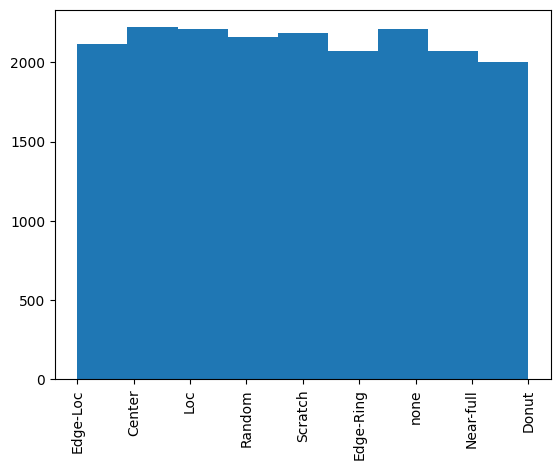

In [ ]:
# Visualize the label distribution after undersampling
n, bins, patches = plt.hist(label_wm, bins=9)
plt.xticks(rotation=90)
plt.show()

In [ ]:
(unique, counts) = np.unique(label_wm, return_counts=True)

# Display the distribution of defect labels
distribution = dict(zip(unique, counts))
print("Defect Distribution:", distribution)

Defect Distribution: {'Center': 2222, 'Donut': 2002, 'Edge-Loc': 2115, 'Edge-Ring': 2072, 'Loc': 2214, 'Near-full': 2072, 'Random': 2159, 'Scratch': 2185, 'none': 2210}


In [ ]:
# Perform One-hot-encoding for labels
for i, l in enumerate(faulty_case):
    label_wm[label_wm==l] = i
    print('i : {}, l : {}'.format(i, l))

def _to_one_hot(y, num_classes):
    scatter_dim = len(y.size())
    y_tensor = y.view(*y.size(), -1)
    zeros = torch.zeros(*y.size(), num_classes, dtype=y.dtype)
    return zeros.scatter(scatter_dim, y_tensor, 1)

label_wm = _to_one_hot(torch.as_tensor(np.int64(label_wm)), num_classes=9)

i : 0, l : Center
i : 1, l : Donut
i : 2, l : Edge-Loc
i : 3, l : Edge-Ring
i : 4, l : Loc
i : 5, l : Near-full
i : 6, l : Random
i : 7, l : Scratch
i : 8, l : none


1. for classification tasks, especially when using models like MobileNet-V2, GoogleNet, or DenseNet121, one-hot encoding is typically required. These models expect the target labels to be in one-hot encoded format, where each class corresponds to a separate output unit.

2. Since my model will have 9 classes (including 'none' and various defect types), one-hot encoding will create a 9-dimensional vector for each sample, where the correct class is marked with a 1 and all other classes are marked with 0

# split data into training and test sets

In [ ]:
from sklearn import model_selection

# Splitting the data into train and test sets
train_X, test_X, train_Y, test_Y = model_selection.train_test_split(resized_wm, label_wm, test_size=0.2)

In [ ]:
train_X.shape

torch.Size([15400, 3, 56, 56])

In [ ]:
test_X.shape

torch.Size([3851, 3, 56, 56])

# Saving train and test data to files

In [ ]:
# Saving train and test data to files
torch.save(train_X, '/content/drive/MyDrive/Colab Notebooks/train_X.pt')
torch.save(test_X, '/content/drive/MyDrive/Colab Notebooks/test_X.pt')
torch.save(train_Y, '/content/drive/MyDrive/Colab Notebooks/train_Y.pt')
torch.save(test_Y, '/content/drive/MyDrive/Colab Notebooks/test_Y.pt')
